# Compare peptigate outputs against RibORF peptide predictions

This notebook compares peptigate peptide predictions against those with ribosomal profiling support.
A recent paper, ["Widespread stable noncanonical peptides identified by integrated analyses of ribosome profiling and ORF features](https://doi.org/10.1038/s41467-024-46240-9) developed a tool called RibORF to carefully predict open reading frames (ORFs) from ribosome profiling data.
Ribosome profiling data is generated by sequencing fragments of mRNA that are protected by ribosomes, offering a snapshot of translation in action at a given moment.
This technique precisely determines which regions of mRNA are being actively translated into proteins, providing insights into gene expression and the regulation of protein synthesis.
The paper used their RibORF tool on hundreds of human ribosomal profiling data sets and predicted ORFs from that data.

RibORF detects specific kinds of ORFs, which we detail in the table below.
The two types of ORFs that peptigate can detect are bolded.
Peptigate might also be able to detect uORF/iORF/dORF/ouORF/odORFs when the input transcripts that are screened are fragmented.

| Type        | Explanation |
|-------------|-------------|
| uORF        | Upstream ORF in the 5' UTR, can regulate the main ORF's translation. |
| **noncoding**   | ORFs not translated into functional proteins, may have regulatory roles. |
| iORF        | Internal ORFs within another ORF's coding sequence, in a different frame. |
| dORF        | Downstream ORF in the 3' UTR, can influence mRNA stability or translation. |
| ouORF       | Overlapping upstream ORF with the main ORF's start, affects main ORF translation. |
| **canonical**   | The primary ORF expected to produce the functional protein. |
| truncation  | ORFs that result in a shorter protein, due to premature start or stop codons. |
| odORF       | Overlapping downstream ORF with the main ORF, potentially affects protein stability. |
| extension   | ORFs extending beyond the canonical stop codon, leading to longer protein products. |
| readthrough | Ribosome ignores the stop codon, extending translation into the 3' UTR. |
| seqerror    | Likely represents ORFs identified due to sequencing errors, not genuine translational events. |


Below, we compare peptigate predictions against RibORF predictions.

## Set up notebook

In [1]:
library(tidyverse)
library(ggExtra)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Compare number and types of predictions

RibORF predicted 57,499 ORFs (filtered to those with a length of 100 or less when translated into amino acids) while peptigate predicted 4,413 sequences.

However, this comparison is not apples: apples.
As noted in the intro to this notebook, RibORF predicts ORFs in coding transcripts that peptigate would ignore.
In this context, the much higher prediction by RibORF as compared to peptigate makes sense.

Further, deeppeptide and nlpprecursor predict cleavage peptides and it isn't clear to me the extent to which we would expect cleavage peptdies to be supported by ribosomal profiling data.

In [2]:
peptigate <- read_tsv("peptigate_results/peptide_predictions.tsv.gz", show_col_types = FALSE) %>%
  rename_with(~paste0("peptigate_", .))

In [3]:
peptigate_distinct <- peptigate %>%
 select(peptigate_prediction_tool, peptigate_protein_sequence) %>%
 distinct()

nrow(peptigate_distinct)

peptigate_distinct %>% group_by(peptigate_prediction_tool) %>% tally()

[1] 4413

peptigate_prediction_tool,n
<chr>,<int>
deeppeptide,1681
nlpprecursor,204
plmutils,2528


In [4]:
riborf <- read_tsv("riborf_human.bed", show_col_types = FALSE,
                   col_names = c("chromosome", "start", "end", "name", 
                                 "score", "strand", "thickStart", "thickEnd",
                                 "itemRgb", "blockCount", "blockSizes", "blockStarts", 
                                 "transcriptInfo")) %>%
  separate(name, into = c("transcript_name", "num_exons", "loc_info", "type", "start_codon"), sep = "\\|", remove = FALSE) %>%
  separate(loc_info, into = c("length", "relative_start", "relative_end"), sep = ":") %>%
  mutate(translated_length = (as.numeric(relative_end) - as.numeric(relative_start)) / 3) %>%
  rename_with(~paste0("riborf_", .))

riborf_100 <- riborf %>%
  filter(riborf_translated_length < 101)

# how many riborf prediction of length < 100 were there?
nrow(riborf_100)

[1] 57499

In [5]:
# what types of ORFs did RibORF detect?
riborf_100 %>% group_by(riborf_type) %>% tally() %>% arrange(desc(n))

riborf_type,n
<chr>,<int>
uORF,28386
noncoding,11251
iORF,5874
dORF,4665
ouORF,4135
canonical,1367
truncation,1205
odORF,571
extension,34


## Do peptigate and RibORF detect some of the same peptide sequences?

To test whether peptigate and RibORF detect some of the same sequences, we BLASTp'd the peptigate peptide predictions against a database of RibORF predictions.
While the majority of peptigate predicted peptides have a hit against the RibORF data, only cleavage peptides (deeppeptide, nlpprecursor) have mostly strong hits (>90% percent identity, >90% query coverage) while sORF peptides (plmutils) do not.

In [6]:
blastp <- read_tsv("peptigate_sequences_vs_riborf_blastp.tsv",
                   col_names = c("qseqid", "qlen", "qseq", "sseqid", "slen", 
                                 "sseq", "pident", "length", "mismatch",
                                 "gapopen", "qstart", "qend", "qcov",
                                 "sstart", "send", "evalue", "bitscore"),
                  show_col_types = F) %>%
  group_by(qseqid) %>%
  slice_max(bitscore) %>%
  slice_min(evalue) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  distinct() %>%
  # join with peptigate results to get prediction tool
  left_join(peptigate, by = c("qseqid" = "peptigate_peptide_id")) %>%
  # remove unwanted columns from peptigate join 
  select(-peptigate_start, -peptigate_end, -peptigate_peptide_class, 
         -peptigate_nlpprecursor_class_score, -peptigate_nlpprecursor_cleavage_score,
         -peptigate_nucleotide_sequence) %>%
  # join with riborf results to get riborf ORF type
  left_join(riborf, by = c("sseqid" = "riborf_name")) %>%
  # remove unwanted columns from riborf join, only keep riborf_type, riborf_start_codon,
  select(-riborf_chromosome, -riborf_start, -riborf_end,
         -riborf_transcript_name, -riborf_num_exons, -riborf_length, 
         -riborf_relative_start, -riborf_relative_end, 
         -riborf_start_codon, -riborf_score, -riborf_strand, -riborf_thickStart, 
         -riborf_thickEnd, -riborf_itemRgb, -riborf_blockCount, -riborf_blockSizes, 
         -riborf_blockStarts, -riborf_translated_length)

In [7]:
# filter to distinct sequences
blastp_distinct <- blastp %>%
  select(-qseqid, -sseqid) %>%
  distinct()

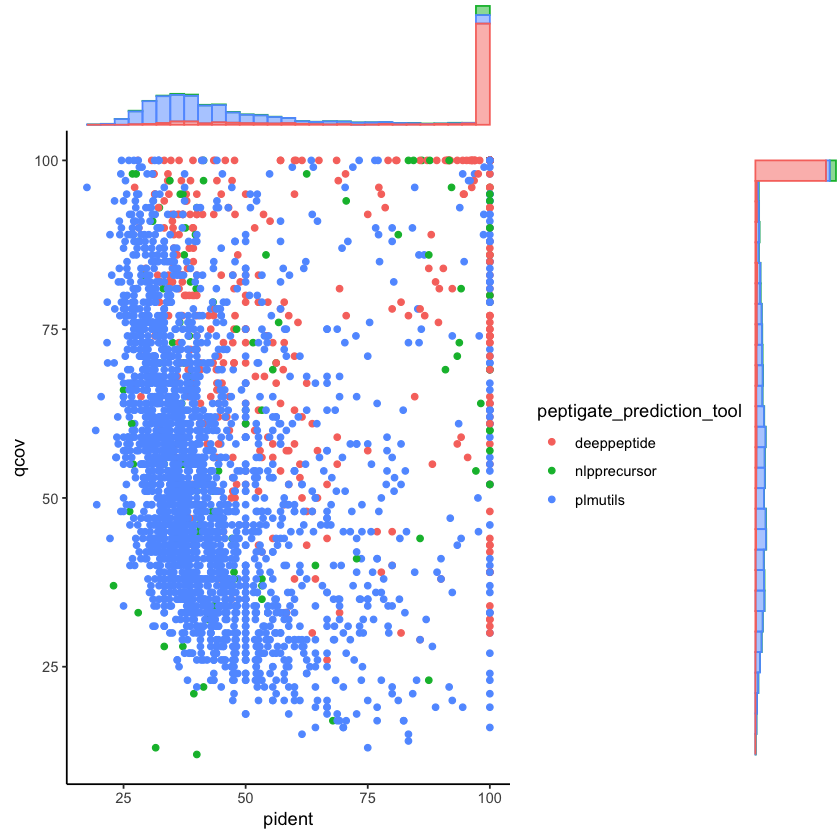

In [8]:
plt1 <- ggplot(blastp_distinct, aes(x = pident, y = qcov, color = peptigate_prediction_tool)) +
  geom_point() +
  theme_classic()

ggMarginal(plt1, type = "histogram", groupColour = T, groupFill = T)

## What types of predictions are validated by the RibORF data?

Peptides predicted by DeepPeptide and NLPPrecursor continue to have the most support in orthogonal data.
Some plmutils predictions have support, but these should be scrutinized more carefully when used for downstream purposes.

As one would expect, we detect overlap with very few uORF/dORF/iORF/ouORF/odORFs.
Peptigate does not have modules to predict these types of ORFs, largely because there are so many of them and they tend to regulate the longer ORF on their transcripts.

In [10]:
blastp_distinct %>% 
  filter(pident > 90) %>%
  group_by(peptigate_prediction_tool, riborf_type) %>%
  summarize(num = n(), 
            mean_pident = mean(pident),
            mean_length = mean(length),
            mean_qcov = mean(qcov)) %>%
  arrange(desc(num))

`summarise()` has grouped output by 'peptigate_prediction_tool'. You can override using the `.groups` argument.


peptigate_prediction_tool,riborf_type,num,mean_pident,mean_length,mean_qcov
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
deeppeptide,canonical,1014,99.85310,22.64103,98.28698
nlpprecursor,canonical,87,99.84224,39.10345,97.57471
plmutils,noncoding,60,99.78698,59.85000,75.60000
deeppeptide,extension,39,100.00000,23.17949,99.07692
plmutils,canonical,35,97.92157,55.28571,70.08571
deeppeptide,truncation,32,100.00000,22.59375,95.68750
deeppeptide,uORF,14,100.00000,21.71429,93.35714
nlpprecursor,truncation,11,97.24173,29.90909,84.81818
plmutils,uORF,5,100.00000,37.40000,83.40000


## Count how many peptigate-predicted peptides had strong evidence in either riborf or peptipedia data

In [48]:
peptigate_annotations_distinct <- read_tsv("peptigate_results/peptide_annotations.tsv.gz", show_col_types = F) %>%
  mutate(peptigate_peptipedia_blast_result = ifelse(!is.na(peptipedia_blast_bitscore), "blast hit", "no blast hit")) %>%
  select(peptigate_peptide_id = peptide_id, peptigate_peptipedia_blast_result) %>%
  left_join(peptigate, by = "peptigate_peptide_id") %>%
  group_by(peptigate_protein_sequence) %>%
  slice_head(n = 1) %>%
  ungroup()

In [44]:
blastp2 <- read_tsv("peptigate_sequences_vs_riborf_blastp.tsv",
                   col_names = c("qseqid", "qlen", "qseq", "sseqid", "slen", 
                                 "sseq", "pident", "length", "mismatch",
                                 "gapopen", "qstart", "qend", "qcov",
                                 "sstart", "send", "evalue", "bitscore"),
                  show_col_types = F) %>%
  group_by(qseqid) %>%
  slice_max(bitscore) %>%
  slice_min(evalue) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  distinct() %>%
  # join with peptigate results to get prediction tool
  right_join(peptigate_annotations_distinct, by = c("qseqid" = "peptigate_peptide_id")) %>%
  # remove unwanted columns from peptigate join 
  select(-peptigate_start, -peptigate_end, -peptigate_peptide_class, 
         -peptigate_nlpprecursor_class_score, -peptigate_nlpprecursor_cleavage_score,
         -peptigate_nucleotide_sequence) %>%
  # join with riborf results to get riborf ORF type
  left_join(riborf, by = c("sseqid" = "riborf_name")) %>%
  # remove unwanted columns from riborf join, only keep riborf_type, riborf_start_codon,
  select(-riborf_chromosome, -riborf_start, -riborf_end,
         -riborf_transcript_name, -riborf_num_exons, -riborf_length, 
         -riborf_relative_start, -riborf_relative_end, 
         -riborf_start_codon, -riborf_score, -riborf_strand, -riborf_thickStart, 
         -riborf_thickEnd, -riborf_itemRgb, -riborf_blockCount, -riborf_blockSizes, 
         -riborf_blockStarts, -riborf_translated_length) %>%
  mutate(riborf_blast_result = ifelse(!is.na(riborf_type), "blast hit", "no blast hit"),
         riborf_blast_result_strong = ifelse(pident >= 90, "blast hit", "no blast hit"))

In [47]:
blastp2 %>%
  mutate(evidence_peptide_is_real = ifelse(peptigate_peptipedia_blast_result == "blast hit" | riborf_blast_result_strong == "blast hit",
                                           "evidence",
                                           "no evidence"),
        evidence_peptide_is_real = ifelse(is.na(evidence_peptide_is_real), "no evidence", evidence_peptide_is_real)) %>%
  group_by(peptigate_prediction_tool, evidence_peptide_is_real) %>%
  tally()

peptigate_prediction_tool,evidence_peptide_is_real,n
<chr>,<chr>,<int>
deeppeptide,evidence,1257
deeppeptide,no evidence,424
nlpprecursor,evidence,130
nlpprecursor,no evidence,74
plmutils,evidence,164
plmutils,no evidence,2364


## Conclusion

As with other tests, we find that predictions for cleavage peptides (made by tools DeepPeptide and NLPPrecursor) continue to be better supported by orthogonal data than those made for sORFs (by plmutils).
However, some plmutls peptides do have support, meaning some predictions are likely real.

In [10]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/pepeval/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggExtra_0.10.0  lubridate_1.9.3 forcats_1.0.0   stringr_1.5.1  
 [5] dplyr_1.1.4     purrr_1.0.2     readr_2.1.5     tidyr_1.3.1    
 [9] tibble_3.2.1    ggplot2_3.5.0   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] utf8_1.2.4       generics_0.1.3   stringi_1.8.3    hms_1.1.3       
 [5] digest_0.6.35    magrittr_2.0.3   evaluate_0.23    grid_4.3.3      
 [9] timechange_0.3.0 pbdZMQ_0.3-11    fastmap_1.1.1    jsonlite_1.8.8  
[13] promises_1.2.1   fansi_1.0.6      sca